# Método para calcular la altura de la marea en un instante prefijado

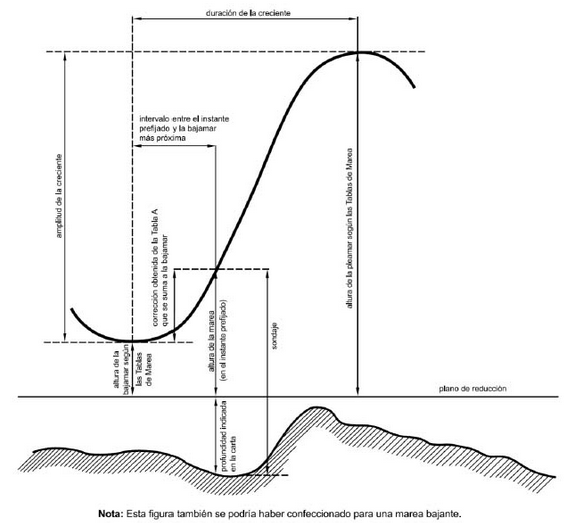

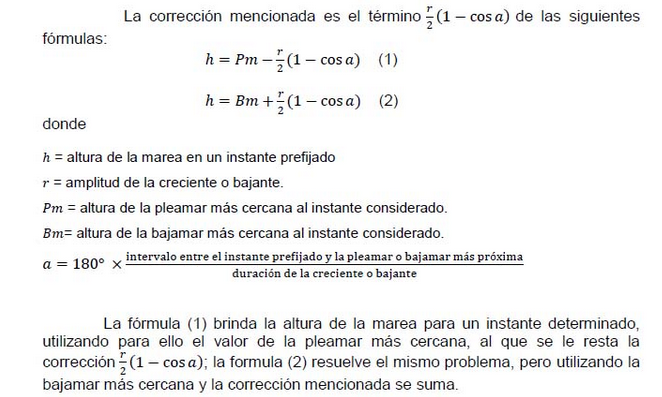

Fuente: SHN.

In [4]:

from datetime import datetime, time
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
%matplotlib notebook
import matplotlib


import sys
import math
from io import StringIO
    
    

In [5]:
def obetener_nombre_mes(month):
    months = ['','Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Setiembre','Octubre','Noviembre','Diciembre']
    if month == 13:
        month = 1
    if month == 0:
        month = 12
    
    return months[month],month
def obtener_dia_mes_anio_hora(date_entered):
    
    day = date_entered.day
    month, month_number = obetener_nombre_mes(int(date_entered.month))
    year = date_entered.year    
    hour = "{:d}:{:02d}".format(date_entered.hour, date_entered.minute)
    
    return day,month,month_number,year,hour

#def obtener_datos_para_el_calculo(day,month,year,hour,location,month_number):
    
def es_bisiesto(anio: int) -> bool:
    return anio % 4 == 0 and (anio % 100 != 0 or anio % 400 == 0)

def obtener_dias_del_mes(mes: int, anio: int) -> int:
    # Abril, junio, septiembre y noviembre tienen 30
    if mes in [4, 6, 9, 11]:
        return 30
    # Febrero depende de si es o no bisiesto
    if mes == 2:
        if es_bisiesto(anio):
            return 29
        else:
            return 28
    else:
        # En caso contrario, tiene 31 días
        return 31
        
def calcular_intervalos_de_tiempo(hour_1, hour_2):
    
    if len(hour_1) == 5:    
        h_1 = int(hour_1[:2])
    else:
        h_1 = int(hour_1[:1])
        
    if len(hour_2) == 5:    
        h_2 = int(hour_2[:2])
    else:
        h_2 = int(hour_2[:1])
    
    m_1 = int(hour_1[-2:])
    m_2 = int(hour_2[-2:])
    
    dh = h_1 - h_2
    dm = m_1 - m_2
    
    dtm = (dh*60) + dm
    
    if dtm < 0:
        dtm *= -1
    return dtm
    
def calcular_altura_marea(fecha_hora,location, df):
    
    
    
    date_entered = datetime.strptime(fecha_hora, "%Y-%m-%d %H:%M:%S")

    day,month,month_number,year,hour = obtener_dia_mes_anio_hora(date_entered)
    register_calc = StringIO('day;hour(min);height(m);month;location;year;tide_type\n'+str(day) + ';' + hour + '')
    df_calculo = pd.read_csv(register_calc,sep=';')
    
    year = int(year)
    day = int(day)
    df_filtered_final=pd.DataFrame()    
    
    
    df_mask = ((df['day'] ==  day) & (df['month'] == month) & (df['year'] == year)
               & (df['location'] == location) )# & (df['tide_type'] == 'Pm')
    
    df_filtered_1 = df[df_mask]
    
    df_filtered_2 = pd.DataFrame()
    df_filtered_0 = pd.DataFrame()
    
    
    month_days = obtener_dias_del_mes(month_number, year)
    
    if day == 1:
        df_mask = ((df['day'] ==  day+1) & (df['month'] == month) & (df['year'] == year)
               & (df['location'] == location) )
        df_filtered_2 = df[df_mask][:1]
        
        if month_number == 1 and year > 2022:
            year = year - 1;
        #if month_number == 12 and year < 2024:
         #   year = year + 1
        
        month,month_number = obetener_nombre_mes(month_number - 1)        
        
        day = obtener_dias_del_mes(month_number, year)
        
        df_mask = ((df['day'] == day) & (df['month'] == month) & (df['year'] == year)
               & (df['location'] == location) )
        df_filtered_0 = df[df_mask][-1:]
        
    if day == month_days:
        df_mask = ((df['day'] ==  day - 1) & (df['month'] == month) & (df['year'] == year)
               & (df['location'] == location) )
        df_filtered_0 = df[df_mask][-1:]
        
        #if month_number == 1 and year > 2022:
         #   year = year - 1;
        if month_number == 12 and year < 2024:
            year = year + 1
        
        month,month_number = obetener_nombre_mes(month_number + 1)        
                
        df_mask = ((df['day'] == 1) & (df['month'] == month) & (df['year'] == year)
               & (df['location'] == location) )
        df_filtered_2 = df[df_mask][:1]
    
    df_comlpete = pd.concat([df_filtered_0,pd.concat([df_calculo,df_filtered_1],axis=0,ignore_index=True).sort_values('hour(min)'), df_filtered_2],ignore_index=True)

    cant_registros = df_comlpete['day'].count()
    lst = list(range(1, cant_registros + 1))
    df_comlpete.insert(loc=1, column='num', value = lst,allow_duplicates=False)
    
    filter=df_comlpete['hour(min)']==hour
    lst_filter=[]
    indice_registro_calculo = 0
    for i in df_comlpete[filter]['num']:
        lst_filter = [i-1,i+1]
        
    for i in lst_filter:
        df_filtered_final=pd.concat([df_filtered_final,df_comlpete[df_comlpete['num'] == i]])
    
    first_tide_type=df_filtered_final['tide_type'][:1]
    cont=0
    r=0
    
    for heigth in df_filtered_final['height(m)']:
        heigth = heigth.replace(',','.')
        if first_tide_type.values[0] == 'Pm':
            if cont == 0:
                r = float(heigth)
                cont += 1
            else:
                r -= float(heigth)            
        else:
            if cont == 0:
                r -= float(heigth)
                cont += 1
            else:
                r += float(heigth)
    
    Pm = float(df_filtered_final[df_filtered_final['tide_type']=='Pm']['height(m)'].values[0].replace(',','.'))
    Bm = float(df_filtered_final[df_filtered_final['tide_type']=='Bm']['height(m)'].values[0].replace(',','.'))
    
    hour_Pm =  df_filtered_final[df_filtered_final['tide_type']=='Pm']['hour(min)'].values[0]
    hour_Bm =  df_filtered_final[df_filtered_final['tide_type']=='Bm']['hour(min)'].values[0]
    
    d_cb = calcular_intervalos_de_tiempo(hour_Pm, hour_Bm)
    intervalo_Pm = calcular_intervalos_de_tiempo(hour_Pm, hour)
    intervalo_Bm = calcular_intervalos_de_tiempo(hour_Bm, hour)
    
    calculo_1 = Pm - ((r/2)*(1-(math.cos(180*((intervalo_Pm/d_cb)/60)))))
    calculo_2 = Bm + ((r/2)*(1-(math.cos(180*((intervalo_Bm/d_cb)/60)))))
    
    print(r, Pm, Bm, hour_Pm, hour_Bm, hour,d_cb, intervalo_Pm, intervalo_Bm,calculo_1,calculo_2)
    
    return r, Pm, Bm, hour_Pm, hour_Bm, hour,d_cb, intervalo_Pm, intervalo_Bm,calculo_1,calculo_2
    


In [6]:
df = pd.read_csv("df_tides_ok_2.csv")
calcular_altura_marea('2022-01-01 01:00:00','ATALAYA',df)
#df.set_index('Unnamed: 0')




0.81 1.22 0.41 13:36 20:33 1:00 417 756 1173 1.0840121375678402 1.038595936841887


(0.81,
 1.22,
 0.41,
 '13:36',
 '20:33',
 '1:00',
 417,
 756,
 1173,
 1.0840121375678402,
 1.038595936841887)

In [7]:
filter_x = (df.year==2023) & (df.tide_type == 'Pm') & (df.location=='PUERTO MAR DEL PLATA')

df_graph_mdq_2023 = df[filter_x]
df_graph_mdq_2023

,Unnamed: 0,day,hour(min),height(m),month,location,year,tide_type
109990,0,1,02:51,"1,18",Enero,PUERTO MAR DEL PLATA,2023,Pm
109992,2,1,15:21,"1,44",Enero,PUERTO MAR DEL PLATA,2023,Pm
109994,4,2,03:44,"1,25",Enero,PUERTO MAR DEL PLATA,2023,Pm
109996,6,2,16:19,"1,37",Enero,PUERTO MAR DEL PLATA,2023,Pm
109998,8,3,04:34,"1,33",Enero,PUERTO MAR DEL PLATA,2023,Pm
...,...,...,...,...,...,...,...,...
111392,111,29,22:05,"1,07",Diciembre,PUERTO MAR DEL PLATA,2023,Pm
111394,113,30,08:56,"1,69",Diciembre,PUERTO MAR DEL PLATA,2023,Pm
111396,115,30,22:54,"1,05",Diciembre,PUERTO MAR DEL PLATA,2023,Pm
111398,117,31,09:33,"1,64",Diciembre,PUERTO MAR DEL PLATA,2023,Pm
